# Spooky Author Identification
![](https://image.freepik.com/free-photo/halloween-pumpkin-on-a-wooden-table_1048-3118.jpg )


# Целите днес: 
- Да разгледаме данните от едно състезание за разпознаване на автор и да видим как се работи със текстови данни 
- Вектори от думи чрез CountVectorizer 
- Стемиране (Stemming) и лематизизация (Lemmatization)
- Tf-idf
- Нагледно използване на кросвалидация, поточни линии (pipelines) и хиперпараметри. 

Да погледнем състезанието: https://www.kaggle.com/c/spooky-author-identification и да си изтеглим данните в `data\`.

In [1]:
# ignore sklearn's convergence warning 
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

In [2]:
import numpy as np

In [4]:
# Dataset
import pandas as pd
train = pd.read_csv("data/spooky-author-identification/train.zip", index_col=['id'])
test = pd.read_csv("data/spooky-author-identification/test.zip", index_col=['id'])
sample_submission = pd.read_csv("data/spooky-author-identification/sample_submission.zip", index_col=['id'])

print(train.shape, test.shape, sample_submission.shape)
print(set(train.columns) - set(test.columns))

(19579, 2) (8392, 1) (8392, 3)
{'author'}


In [5]:
train.head(5)

,text,author
id,,
id26305,"This process, however, afforded me no means of...",EAP
id17569,It never once occurred to me that the fumbling...,HPL
id11008,"In his left hand was a gold snuff box, from wh...",EAP
id27763,How lovely is spring As we looked from Windsor...,MWS
id12958,"Finding nothing else, not even gold, the Super...",HPL


# Авторите

### EAP - Едгар Алън По 
* американски писател
* Гарванът
* 19 януари 1809 г.

### HPL - Хауърд Филипс Лъвкрафт 
* американски писател
* Ктхулу цикъл 
* 20 август 1890 г.

### MWS - Мери Уолстонкрафт Шели 
* английска писателка
* Франкенщайн
* 30 август 1797 г.
    

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

train.author = train.author.replace(['EAP', 'HPL', 'MWS'], ['Едгар', 'Хауърд', 'Мери'])

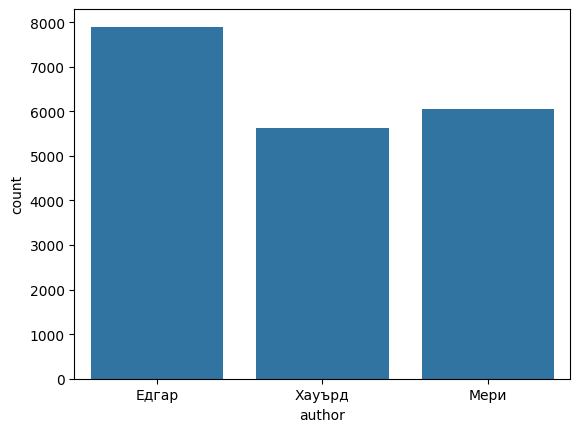

In [7]:
sns.countplot(data=train, x='author');

In [8]:
all_words = train['text'].str.split(expand=True).unstack().value_counts()
all_words.head(15)

the     33296
of      20851
and     17059
to      12615
I       10382
a       10359
in       8787
was      6440
that     5988
my       5037
had      4324
with     4207
his      3802
as       3528
he       3422
Name: count, dtype: int64

In [9]:
all_words.tail(15)

manuscript,     1
Herrero,        1
unkemptness;    1
augmented;      1
depraved        1
delighting      1
whither?        1
gland,          1
destroys        1
enquires        1
animator        1
withers         1
wayward         1
worlds"         1
prophetess,     1
Name: count, dtype: int64

* Най-честите думи са общи.
* В най-редките има имена.
* Също така има и препинателни знаци.

In [10]:
eap = train[train.author=="Едгар"].text.values
hpl = train[train.author=="Хауърд"].text.values
mws = train[train.author=="Мери"].text.values


# Идеи за характеристики:
    
* Вектори на думи - CountVectorizer, Tfidf
* Предварителна обработка - стоп-думи (stop words), лематизация
* Други характеристики - бр. думи , бр. стоп думи, бр. пунктуация, бр. ГЛАВНИ букви и т.н.
* Намиране на общи теми чрез LDA
* Вграждания на думи (Word Embeddings) с невронни мрежи


# Първо - базов модел

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score

In [16]:
pipeline = Pipeline([
    ('features', CountVectorizer()),
    ('clf', LinearSVC())
])

cross_val_score(pipeline, train.text, train.author, cv=3, n_jobs=3)

array([0.7878045 , 0.79635305, 0.79512718])

Да проверим какво е научил `CountVectorizer`:

In [17]:
pipeline.fit(train.text, train.author)
count_vectorizer = pipeline.steps[0][1]
count_vectorizer

,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None
,stop_words,None
,token_pattern,'(?u)\\b\\w\\w+\\b'
,ngram_range,"(1, ...)"
,analyzer,'word'


In [18]:
list(count_vectorizer.vocabulary_.items())[:15]

[('this', 22175),
 ('process', 17139),
 ('however', 10784),
 ('afforded', 455),
 ('me', 13678),
 ('no', 14817),
 ('means', 13696),
 ('of', 15145),
 ('ascertaining', 1300),
 ('the', 22085),
 ('dimensions', 6133),
 ('my', 14491),
 ('dungeon', 6898),
 ('as', 1287),
 ('might', 13930)]

# Как работи CountVectorizer?
Другото му име е "bag of words".

Подобно на one-hot encoding, но за текст.


1. Когато се извика `fit` - прави речник с всички думи в корпуса и им поставя индекс за всяка уникална дума. 
2. Когато се извика `transform` - взима текста от всеки ред и го превръща във вектор, където отбелязва броя на всяка дума от вектора.


* Може да брои думите или само да отбелязва наличието им двоично.
* Може да работи и с поредици от думи - n-грами (n-grams).
* А може да работи и на ниво символи или каквото му подадем за разделител.

In [19]:
vectorizer = CountVectorizer()
corpus = [
    "Billions and billions of dollars",
    "A lot of money",
    "We are going to make",
    "We are going ot take care of"
]
print(vectorizer.fit_transform(corpus).todense())
print(vectorizer.vocabulary_)

[[1 0 2 0 1 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 1 0 1 1 0 0 0 0]
 [0 1 0 0 0 1 0 1 0 0 0 0 1 1]
 [0 1 0 1 0 1 0 0 0 1 1 1 0 1]]
{'billions': 2, 'and': 0, 'of': 9, 'dollars': 4, 'lot': 6, 'money': 8, 'we': 13, 'are': 1, 'going': 5, 'to': 12, 'make': 7, 'ot': 10, 'take': 11, 'care': 3}


Супер, да покажем и двуграми:

In [20]:
vectorizer = CountVectorizer(ngram_range=(1,2))
print(vectorizer.fit_transform(corpus).todense())
print(vectorizer.vocabulary_)

[[1 1 0 0 2 1 1 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 0 1 0 0 0 0 0 0 0 0]
 [0 0 1 1 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 1 1 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 0 1 1 1 1 0 0 1 1]]
{'billions': 4, 'and': 0, 'of': 17, 'dollars': 9, 'billions and': 5, 'and billions': 1, 'billions of': 6, 'of dollars': 18, 'lot': 13, 'money': 16, 'lot of': 14, 'of money': 19, 'we': 26, 'are': 2, 'going': 10, 'to': 24, 'make': 15, 'we are': 27, 'are going': 3, 'going to': 12, 'to make': 25, 'ot': 20, 'take': 22, 'care': 7, 'going ot': 11, 'ot take': 21, 'take care': 23, 'care of': 8}


Това беше кратко отклонение за да видим как работи CountVectorizer.

Да се върнем на модела и да погледнем какви са предсказанията:

In [23]:
from sklearn.model_selection import cross_val_predict
prediction = cross_val_predict(pipeline, train.text, train.author, cv=3, n_jobs=3)
prediction

array(['Едгар', 'Едгар', 'Хауърд', ..., 'Едгар', 'Едгар', 'Хауърд'],
      shape=(19579,), dtype=object)

Забележете магията - не ползвахме `LabelEncoder` за класовете.

`sklearn` е достатъчно умен да се оправи сам с категориинете данни в `y`.

In [24]:
import itertools
from sklearn.metrics import confusion_matrix, accuracy_score

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          figsize=(9, 7)):
    matrix = confusion_matrix(y_true, y_pred)

    if normalize:
        matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=figsize)
    plt.imshow(matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, format(matrix[i, j], fmt),
                 horizontalalignment="center",
                 size=int((figsize[0] / 10) * 38),
                 color="white" if matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

0.7930946422187037


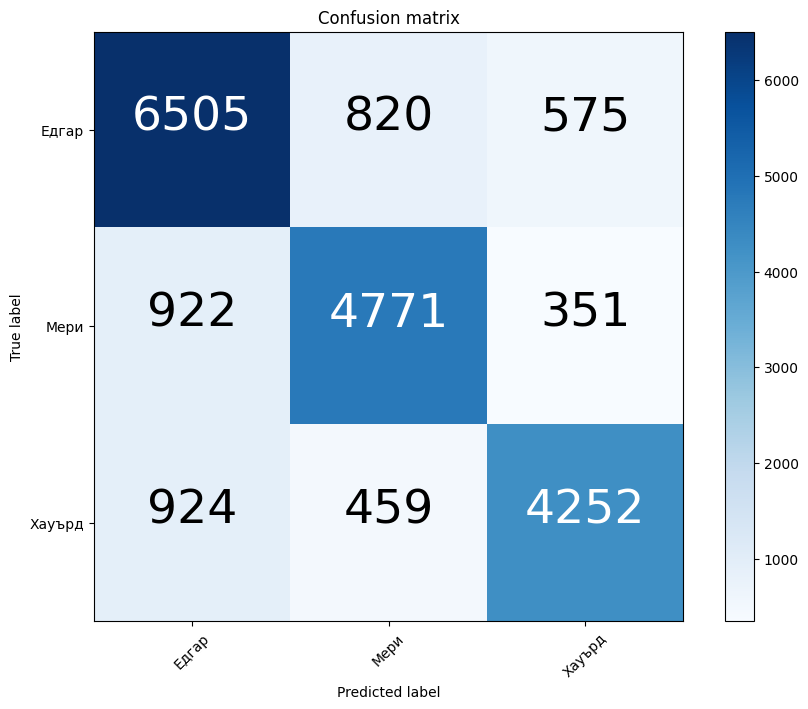

In [25]:
authors = pipeline.classes_
print(accuracy_score(train.author, prediction))
plot_confusion_matrix(train.author, prediction, classes=authors)

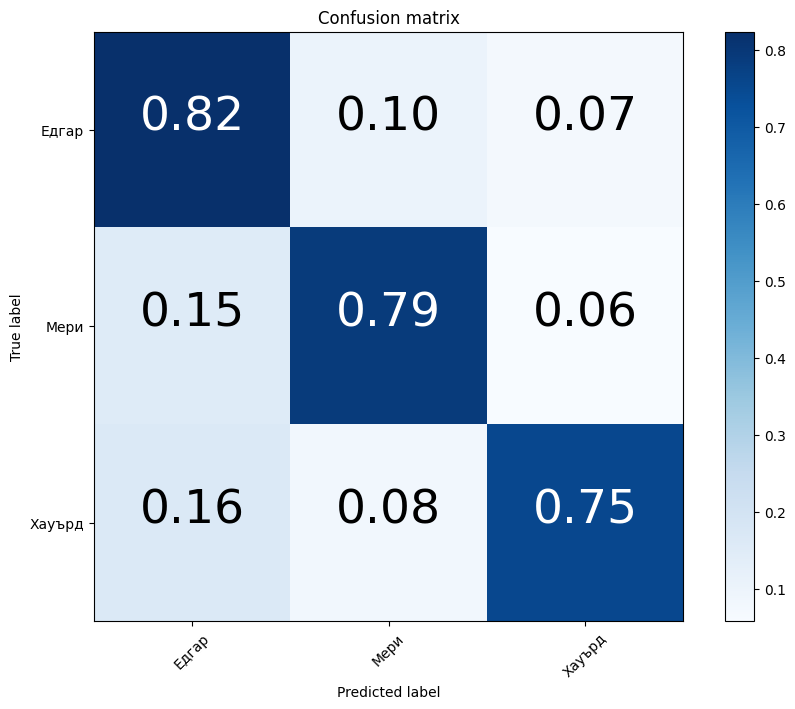

In [26]:
plot_confusion_matrix(train.author, prediction, classes=authors, normalize=True)

Да пробваме с RF:

In [27]:
from sklearn.ensemble import RandomForestClassifier
pipeline = Pipeline([
    ('features', CountVectorizer()),
    ('clf', RandomForestClassifier())
])

cross_val_score(pipeline, train.text, train.author, cv=3, n_jobs=3)

array([0.68454114, 0.69031566, 0.69123506])

В състезанието пише, че оценката ще се мери с `LogLoss`.

Да видим каквъв резултат ще получим с тази метрика.

In [29]:
cross_val_score(pipeline, train.text, train.author, 
                cv=3, n_jobs=3, scoring='neg_log_loss')

array([-0.79235548, -0.78730592, -0.78197969])

И с линейна регресия, защото LinearSVC няма `predict_proba` по подразбиране.

За да се добави, може да се използва `decision_function` + `softmax`.

In [30]:
from sklearn.linear_model import LogisticRegression

pipeline = Pipeline([
    ('features', CountVectorizer()),
    ('clf', LogisticRegression())
])

print(cross_val_score(pipeline, train.text, train.author, cv=3, n_jobs=3))
print(cross_val_score(pipeline, train.text, train.author, cv=3, n_jobs=3, 
                      scoring='neg_log_loss'))

# Получихме малко по-добри резултати

[0.80910066 0.80922464 0.81045051]
[-0.478522   -0.47282987 -0.46809471]


Добре, този модел ще го оптимизираме доста.

Какви други характеристики можем да измислим?

### Може да има сигнал в:
* бр. "stopwords"
* бр. на препинателни знаци
* бр. главни букви
* бр. на думи съдържащи само главни буква
* бр. на цифрите в текста
* средна дължина на дума

### Тези може да вкарат и шум:
* бр. думи в текста
* бр. уникални думи в текста 
* бр. символи в текста 

In [31]:
explore = train.copy()

# бр. думи в текста
explore['words'] = explore.text.apply(lambda s: len(str(s).split()))

# бр. уникални думи
explore['unique_words'] = explore.text.apply(lambda s: len(set(str(s).split())))

# бр. символи
explore['symbols'] = explore.text.str.len()

# бр. уникални символи
explore['unique_symbols'] = explore.text.apply(lambda s: len(set(str(s))))

In [32]:
import string

# бр. главни букви
explore['capital_letters'] = explore.text.apply(lambda s: sum([str.isupper(c) for c in str(s)]))

# бр. на думи съдържащи само главни буква
explore['only_capital_letter_words'] = explore.text.apply(lambda s: sum([str.isupper(w) for w in str(s).split()]))

# средна дължина на дума
explore['average_word_lenght'] = explore.text.apply(lambda s: np.mean([len(w) for w in str(s).split()]))

# бр. цифрите
explore['digits'] = explore.text.apply(lambda s: sum([str.isdigit(c) for c in str(s)]))

# бр. на препинателни знаци
train["punctuation"] = train.text.apply(lambda s: sum([c in string.punctuation for c in str(s)]) )

print(string.punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [35]:
# !pip install nltk

import nltk
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')
print(len(stopwords))
print(stopwords)

198
['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Berbatova\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [36]:
explore['stop_words'] = explore.text.apply(lambda s: sum(w in stopwords for w in str(s).split()))

In [37]:
explore.head()

,text,author,words,unique_words,symbols,unique_symbols,capital_letters,only_capital_letter_words,average_word_lenght,digits,stop_words
id,,,,,,,,,,,
id26305,"This process, however, afforded me no means of...",Едгар,41,35,231,28,3,2,4.658537,0,16
id17569,It never once occurred to me that the fumbling...,Хауърд,14,14,71,22,1,0,4.142857,0,7
id11008,"In his left hand was a gold snuff box, from wh...",Едгар,36,32,200,26,1,0,4.583333,0,15
id27763,How lovely is spring As we looked from Windsor...,Мери,34,32,206,30,4,0,5.088235,0,11
id12958,"Finding nothing else, not even gold, the Super...",Хауърд,27,25,174,27,2,0,5.481481,0,11


Ще създадем един списък, в който да се пазят имената на характеристиките.

In [38]:
print(explore.columns)
features_names = list(set(explore.columns) - {'text', 'author'})

Index(['text', 'author', 'words', 'unique_words', 'symbols', 'unique_symbols',
       'capital_letters', 'only_capital_letter_words', 'average_word_lenght',
       'digits', 'stop_words'],
      dtype='object')


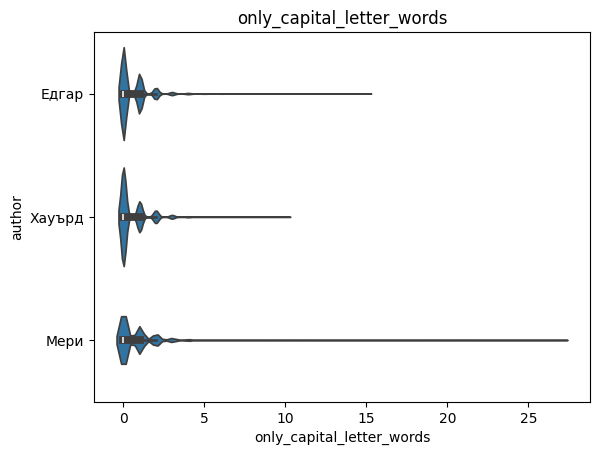

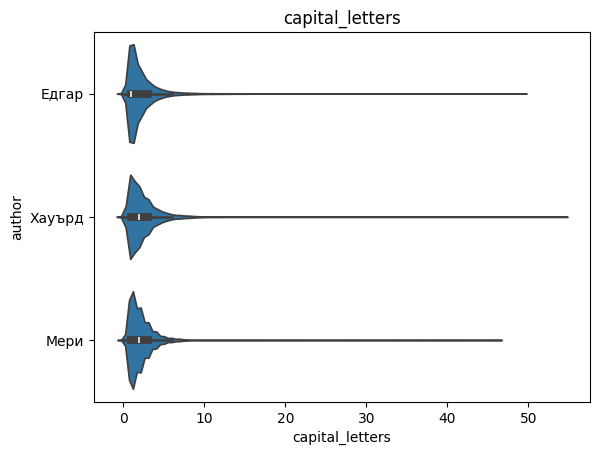

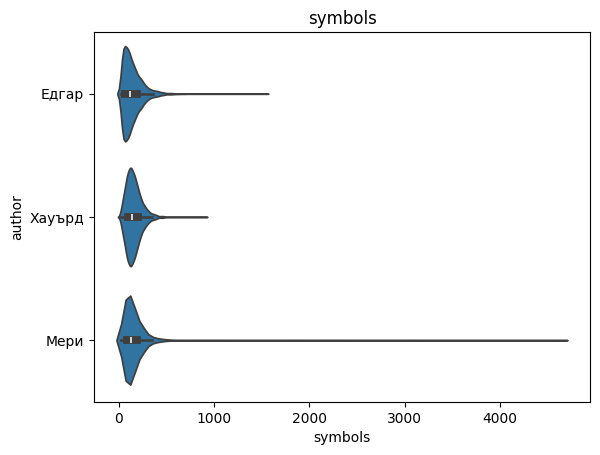

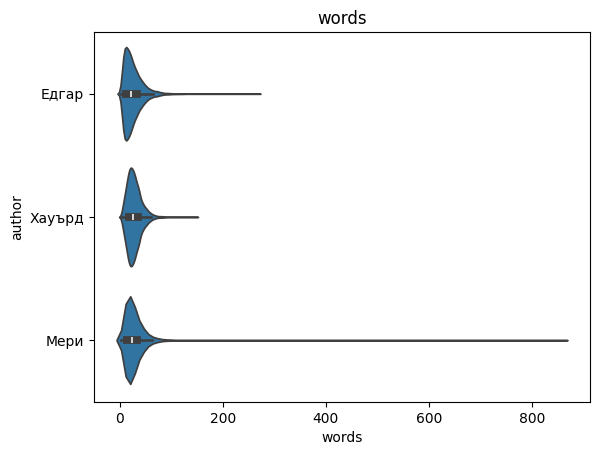

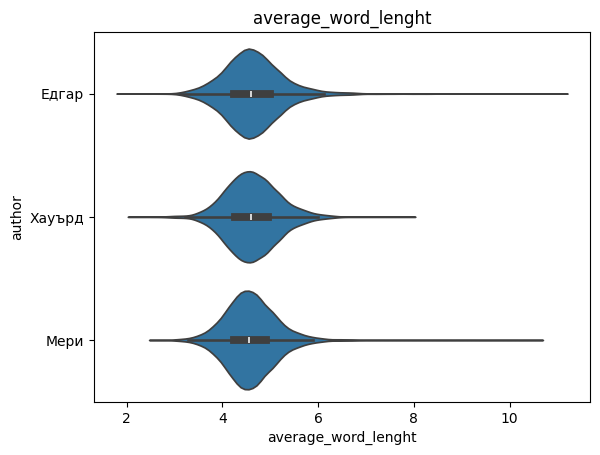

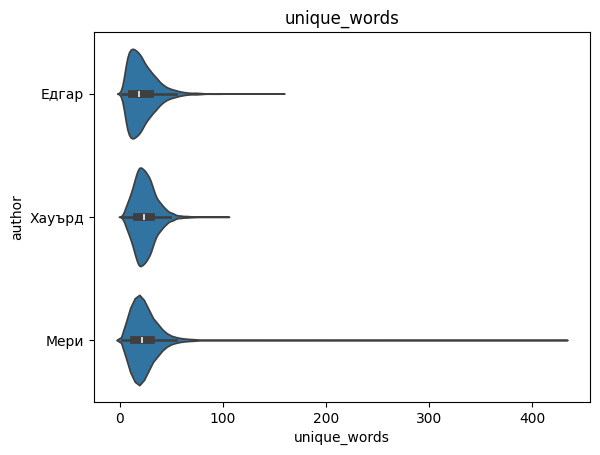

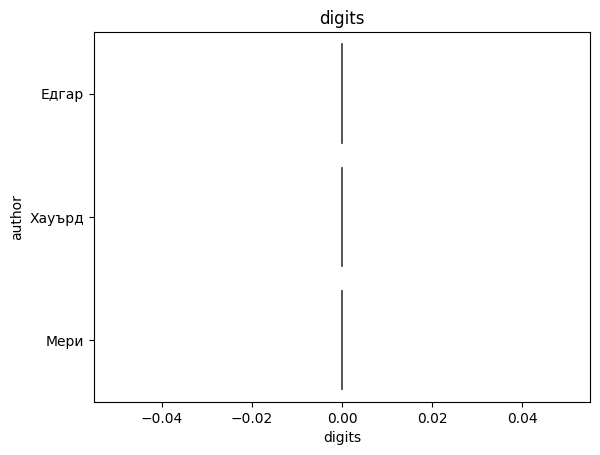

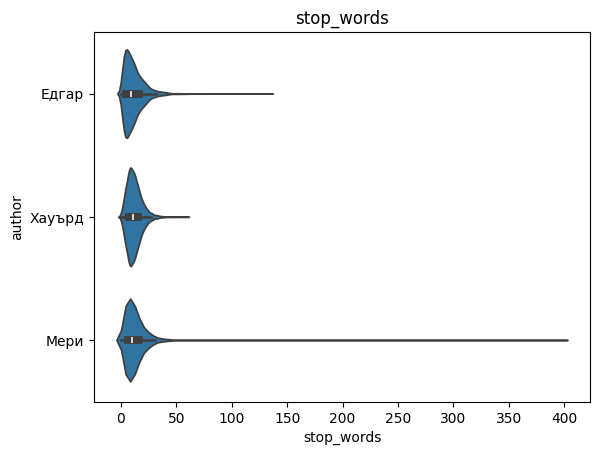

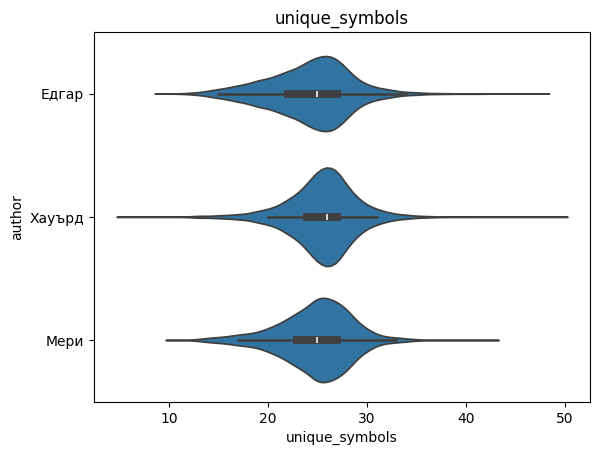

In [39]:
for feature in features_names:
    plt.figure()
    sns.violinplot(x=feature, y="author", data=explore)
    plt.title(feature);

Информация за Violin plots - [тук](https://mode.com/blog/violin-plot-examples/).

Няма много вариация в разпределенията на фичърите.

Нека все пак натренираме модел с тях да видим как ще се държи.

In [40]:
from sklearn.ensemble import RandomForestClassifier
cross_val_score(RandomForestClassifier(), explore[features_names], explore.author, cv=3, n_jobs=3)

array([0.42056075, 0.40622127, 0.41296353])

In [41]:
cross_val_score(LinearSVC(), explore[features_names], explore.author, cv=3, n_jobs=1)

array([0.45733109, 0.44406987, 0.44728777])

Не е много добре.

Да видим какво показва матрицата на грешките.

0.41130803411818784


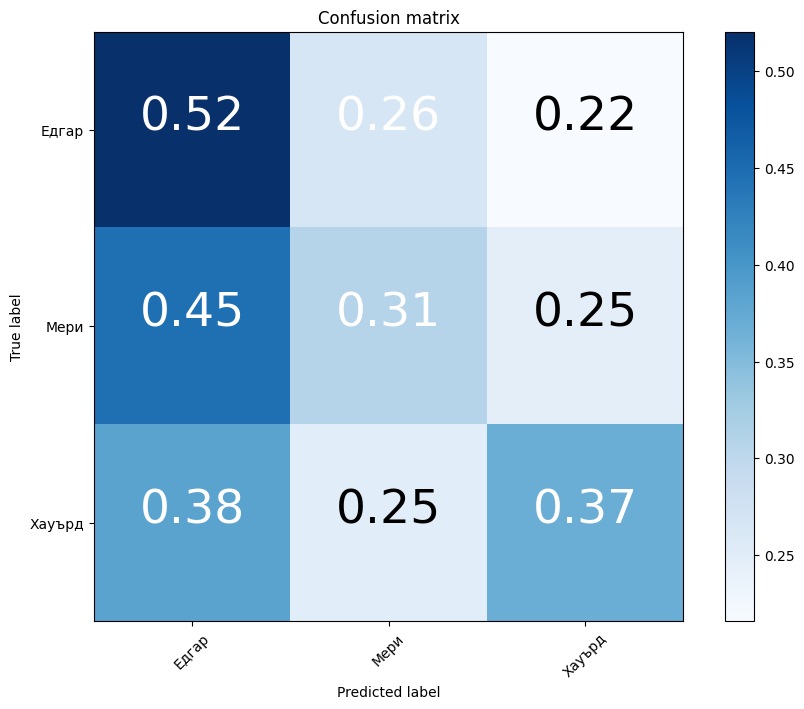

In [42]:
predict_from_features = cross_val_predict(RandomForestClassifier(), explore[features_names], explore.author, cv=3, n_jobs=3)
print(accuracy_score(explore.author, predict_from_features))
plot_confusion_matrix(explore.author, predict_from_features, classes=authors, normalize=True)

Да погледнем какво е разпределението на оригиналните класове.

In [43]:
explore.author.value_counts(normalize=True) 

author
Едгар     0.403494
Мери      0.308698
Хауърд    0.287808
Name: proportion, dtype: float64

Моделите са почти със същата точност като константния (този, в който предсказваме само най-популярния клас).

Тези характеристики може и да са полезни в някой нелинеен модел в комбинация с други характеристики, но за сега ги оставяме.

Ще изчистим текста от окончания за множествено число, времена и други.

За целта може да се ползва **стемиране** (stemming) или **лематизация** (lemmatization). 

На кратко, стемирането:
* Премахва окончанията на думите като ~_ing_, ~_ed_, ~_es_, ~_ly_ и др. окончания от всички думи.

Лематизацията:
* Работи с речник и намира правилната форма на думите. 
* Разбира и от синтаксис - знае дали думата е съществително или глагол, напр. "meeting".

In [44]:
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

stem = PorterStemmer()

explore['stemmed'] = explore.text.apply(lambda t: " ".join([stem.stem(w) for w in t.split()])) 

explore[['stemmed', 'text']].head()

,stemmed,text
id,,
id26305,"thi process, however, afford me no mean of asc...","This process, however, afforded me no means of..."
id17569,it never onc occur to me that the fumbl might ...,It never once occurred to me that the fumbling...
id11008,"in hi left hand wa a gold snuff box, from whic...","In his left hand was a gold snuff box, from wh..."
id27763,how love is spring as we look from windsor ter...,How lovely is spring As we looked from Windsor...
id12958,"find noth else, not even gold, the superintend...","Finding nothing else, not even gold, the Super..."


In [46]:
print(explore.text.iloc[0])
print()
print(explore.stemmed.iloc[0])

This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.

thi process, however, afford me no mean of ascertain the dimens of my dungeon; as i might make it circuit, and return to the point whenc i set out, without be awar of the fact; so perfectli uniform seem the wall.


In [47]:
pipeline = Pipeline([
    ('features', CountVectorizer()),
    ('clf', LinearSVC())
])

cross_val_score(pipeline, explore.stemmed, train.author, cv=3, n_jobs=3)

# Резултати от същия pipeline използвайки колона text:
# array([ 0.78783701,  0.79635305,  0.79509579])

array([0.78474031, 0.78547349, 0.78486056])

### Допълнителните характеристики не сработиха, стемирането също. 

Остават да пробвамe:

* Оптимизиране на модела с CountVectorizer.
* Добавяне на още характеристики, от латентни пространства (LDA) - topic modeling.
* Word embeddings с невронни мрежи.
* Ансамбъл от на класификатори (stacking).

За сега ще разгледаме само оптимизирането на модела.

### Има няколко разновидности на `CountVectorizer` и всичките имат голям набор параметри. 

* CountVectorizer
* TfidfVectorizer
* HashingVectorizer

### Някои от основните параметри са:
* analyzer=’word’
* ngram_range=(1, 1)
* token_pattern=’(?u)\b\w\w+\b’
* max_df=1.0, min_df=1
* max_features=None, 
* lowercase=True
* preprocessor=None
* tokenizer=None
* stop_words=None

### Искаме да пробваме с различни класификатори.

Пространството за изследване става огромно и ще си помогнем с `RandomSearch` от sklearn.

Освен това ще трябва да гледаме `LogLoss` за оценка, а не `Accuracy`, защото състезанието иска това и вероятностите имат значение.

Първо да опишем параметрите за търсене в трансфомацията (CountVectorizer)

In [48]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer

params_count_word = {"features__ngram_range": [(1,1), (1,2), (1,3)],
                      "features__analyzer": ['word'],
                      "features__max_df":[1.0, 0.9, 0.8, 0.7, 0.6, 0.5],
                      "features__min_df":[2, 3, 5, 10],
                      "features__lowercase": [False, True],
                      "features__stop_words": [None, stopwords]}

params_count_char = {"features__ngram_range": [(1,4), (1,5), (1,6)],
                      "features__analyzer": ['char'],
                      "features__max_df":[1.0, 0.9, 0.8, 0.7, 0.6, 0.5],
                      "features__min_df":[2, 3, 5, 10],
                      "features__lowercase": [False, True],
                      "features__stop_words": [None, stopwords]}

In [49]:
def report(results, n_top=5):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


In [50]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import log_loss
def random_search():
    params = {
        "clf__C": [0.01, 0.1, 0.3, 1, 3, 10],
        "clf__class_weight": [None, 'balanced']
    }

    params.update(params_count_word)

    pipeline = Pipeline([
        ('features', CountVectorizer()),
        ('clf', LogisticRegression())
    ])

    random_search = RandomizedSearchCV(pipeline, param_distributions=params, 
                                       scoring='neg_log_loss',
                                       n_iter=20, cv=3, n_jobs=4)

    random_search.fit(train.text, train.author)
    report(random_search.cv_results_)

# random_search()

Model with rank: 1
Mean validation score: -0.475 (std: 0.002)
Parameters: {'features__stop_words': None, 'features__ngram_range': (1, 1), 'features__lowercase': True, 'features__analyzer': 'word', 'clf__class_weight': None, 'clf__C': 1}

Model with rank: 2
Mean validation score: -0.482 (std: 0.002)
Parameters: {'features__stop_words': None, 'features__ngram_range': (1, 2), 'features__lowercase': True, 'features__analyzer': 'word', 'clf__class_weight': None, 'clf__C': 1}

Model with rank: 3
Mean validation score: -0.486 (std: 0.001)
Parameters: {'features__stop_words': None, 'features__ngram_range': (1, 1), 'features__lowercase': True, 'features__analyzer': 'word', 'clf__class_weight': 'balanced', 'clf__C': 3}

Model with rank: 4
Mean validation score: -0.508 (std: 0.004)
Parameters: {'features__stop_words': None, 'features__ngram_range': (1, 2), 'features__lowercase': False, 'features__analyzer': 'word', 'clf__class_weight': 'balanced', 'clf__C': 0.3}

Model with rank: 5
Mean validation score: -0.525 (std: 0.004)
Parameters: {'features__stop_words': None, 'features__ngram_range': (1, 3), 'features__lowercase': True, 'features__analyzer': 'word', 'clf__class_weight': 'balanced', 'clf__C': 0.3}


Търсенето отнеме много време, заради това за `char-grams` ще пуснeм само едно трениране и оценяване с по-стандартни стойности на хипер параметрите.

In [51]:
pipeline = Pipeline([
    ('features', CountVectorizer(ngram_range=(3,5), analyzer='char')),
    ('clf', LogisticRegression())
])

print(cross_val_score(pipeline, train.text, train.author, cv=3, n_jobs=3))
print(cross_val_score(pipeline, train.text, train.author, cv=3, n_jobs=3, scoring='neg_log_loss'))

[0.8066493  0.80462764 0.81474104]
[-0.61951319 -0.61447929 -0.57454903]


По-лоши резултати с chars - няма да го изследваме.

За сметка на това ще пробваме да заменим `CountVectorizer` с по-големия му батко `Tfidf`.

# Tfidf = Term frequency-inverse document-frequency

* Идеята е да сложи тежести и значимост на всички думи или n-грами.
* Напр. "новина" е доста често срещана дума и може да бъде в различни контексти. 
* За разлика от "електроенцефалограф", която е много по-рядко срещана и директно дава медицински контекст.


* TF (term frequency) брои колко пъти се среща думата в текущия текст (пасаж, изречение, документ).
* IDF (inverse document frequency) брои колко пъти тази дума се среща изцяло в корпуса, с който тренираме.

# Има и формула 

$$
    \operatorname {tfidf} (w,d) = \operatorname{tf} * \log \Big(  \frac{n+1}{n_w + 1} \Big )  + 1
$$

където:

* $w$ - конкретна дума
* $d$ - документ, на койито правим трансформация
* $n$ - бр. на документите в тренировъчното множество
* $n_w$ - бр. на документите, в които $w$ се среща
* $\operatorname{tf}$ - бр. срещанията на думата $w$ в документа $d$

# Например

* "екстраполирам" се среща 10 пъти в 1000 документа корпус.
* "за" се среща в 900 от 1000.


$$
\text{tfidf("екстраполирам", "екстраполирам нещо си")} = 1 * log(1001 / 11) + 1 = 5.51
$$

$$
\text{tfidf("за", "отиде да тича за нещо си... за да му дойде акъла")} = 2 * log(1001 / 901) + 1 = 1.21
$$

In [52]:
print(1 * np.log(1001 / 11) + 1)
print(2 * np.log(1001 / 901) + 1)

5.51085950651685
1.2104990434137652


In [53]:
tfidf = TfidfVectorizer()
print(tfidf.fit_transform(corpus).todense())
print(tfidf.vocabulary_)

[[0.39505606 0.         0.79011212 0.         0.39505606 0.
  0.         0.         0.         0.25215917 0.         0.
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.64450299 0.         0.64450299 0.41137791 0.         0.
  0.         0.        ]
 [0.         0.40104275 0.         0.         0.         0.40104275
  0.         0.50867187 0.         0.         0.         0.
  0.50867187 0.40104275]
 [0.         0.34336615 0.         0.43551643 0.         0.34336615
  0.         0.         0.         0.27798449 0.43551643 0.43551643
  0.         0.34336615]]
{'billions': 2, 'and': 0, 'of': 9, 'dollars': 4, 'lot': 6, 'money': 8, 'we': 13, 'are': 1, 'going': 5, 'to': 12, 'make': 7, 'ot': 10, 'take': 11, 'care': 3}


In [54]:
CountVectorizer().fit(corpus).vocabulary_ == TfidfVectorizer().fit(corpus).vocabulary_ 

True

Горното сравнение ще рече, че `CountVectorizer` и `TfidfVectorizer` намирът един и същи речник или "торбата с думи".

Това е така защото `TfidfVectorizer` вътрешно ползва `CountVectorizer` а отгоре само добавя idf функционалността.

In [55]:
print(tfidf.idf_)

[1.91629073 1.51082562 1.91629073 1.91629073 1.91629073 1.51082562
 1.91629073 1.91629073 1.91629073 1.22314355 1.91629073 1.91629073
 1.91629073 1.51082562]


In [ ]:
def random_search():
    params = {
        "clf__C": [0.01, 0.1, 0.3, 1, 3, 10],
        "clf__class_weight": [None, 'balanced']
    }

    params.update(params_count_word)

    pipeline = Pipeline([
        ('features', TfidfVectorizer()),
        ('clf', LogisticRegression())
    ])

    random_search = RandomizedSearchCV(pipeline, param_distributions=params, 
                                       scoring='neg_log_loss',
                                       n_iter=20, cv=3, n_jobs=4)

    random_search.fit(train.text, train.author)
    report(random_search.cv_results_)

    print("Best params: ", random_search.best_params_)

# random_search() # предишния най-добър резултат:  -0.475 

Model with rank: 1
Mean validation score: -0.478 (std: 0.005)
Parameters: {'features__stop_words': None, 'features__ngram_range': (1, 1), 'features__min_df': 2, 'features__max_df': 0.7, 'features__lowercase': False, 'features__analyzer': 'word', 'clf__class_weight': None, 'clf__C': 3}

Model with rank: 2
Mean validation score: -0.491 (std: 0.006)
Parameters: {'features__stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in'

Има леко подобрение в `LogLoss`.

Да пробваме да сменим и класификатора с друг класически за класификация на текст: `Naive Bayes`

In [ ]:
def random_search():
    params = {
        "clf__alpha": [0.01, 0.1, 0.5, 1, 2]
    }

    params.update(params_count_word)

    pipeline = Pipeline([
        ('features', TfidfVectorizer()),
        ('clf', MultinomialNB())
    ])

    random_search = RandomizedSearchCV(pipeline, param_distributions=params, 
                                       scoring='neg_log_loss',
                                       n_iter=20, cv=3, n_jobs=4)

    random_search.fit(train.text, train.author)
    report(random_search.cv_results_)

    print(random_search.best_params_)

random_search()  # Предишния най-добър резултат: -0.469

Model with rank: 1
Mean validation score: -0.446 (std: 0.001)
Parameters: {'features__stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', '

Тук има още подобрение в метриката.

Искамe да го пробвамe и със стемиране.

Освен това се вижда, че избира най-ниската предоставена стойност за `alpha`, може би трябва да пробвамe с още по-ниски.

In [ ]:
def random_search():
    params = {
        "clf__alpha": [0.001, 0.005, 0.01, 0.05, 0.1, 0.3]
    }

    params.update(params_count_word)

    pipeline = Pipeline([
        ('features', TfidfVectorizer()),
        ('clf', MultinomialNB())
    ])

    random_search = RandomizedSearchCV(pipeline, param_distributions=params, 
                                       scoring='neg_log_loss',
                                       n_iter=20, cv=3, n_jobs=4)

    random_search.fit(explore.stemmed, train.author)
    report(random_search.cv_results_)
    
#random_search()  # -0.423

Model with rank: 1
Mean validation score: -0.421 (std: 0.003)
Parameters: {'features__stop_words': None, 'features__ngram_range': (1, 2), 'features__min_df': 2, 'features__max_df': 0.7, 'features__lowercase': True, 'features__analyzer': 'word', 'clf__alpha': 0.05}

Model with rank: 2
Mean validation score: -0.436 (std: 0.003)
Parameters: {'features__stop_words': None, 'features__ngram_range': (1, 3), 'features__min_df': 2, 'features__max_df': 0.7, 'features__lowercase': True, 'features__analyzer': 'word', 'clf__alpha': 0.1}

Model with rank: 3
Mean validation score: -0.443 (std: 0.004)
Parameters: {'features__stop_words': None, 'features__ngram_range': (1, 3), 'features__min_df': 3, 'features__max_df': 0.8, 'features__lowercase': False, 'features__analyzer': 'word', 'clf__alpha': 0.05}

Model with rank: 4
Mean validation score: -0.465 (std: 0.006)
Parameters: {'features__stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'ar

### Откри приблизително същите параметри, но не успя да стигне напълно до същия резултат.

Ще използвамe следния модел:

TfIdf + MultinomialNB, без стемиране на текста.

Mean validation score: -0.423 (std: 0.003)

Ще ползвамe и следните параметри:

Parameters: {'features__stop_words': None, 'features__ngram_range': (1, 2), 'features__min_df': 2, 'features__max_df': 0.8, 'features__lowercase': False, 'features__analyzer': 'word', 'clf__alpha': 0.01}

Последна проверка на този модел за `LogLoss` и `Accuracy`:

In [64]:
from sklearn.naive_bayes import MultinomialNB

pipeline = Pipeline([
    ('features', TfidfVectorizer(ngram_range=(1, 2), min_df=2,
                                 max_df=0.8, lowercase=False)),
    ('clf', MultinomialNB(alpha=0.01))
])

print(cross_val_score(pipeline, train.text, train.author, cv=3, n_jobs=3))
print(cross_val_score(pipeline, train.text, train.author, cv=3, n_jobs=3, 
                      scoring='neg_log_loss'))

[0.83192891 0.83466135 0.83205639]
[-0.42536717 -0.41843618 -0.42490889]


# Трениране на модел и предаване

Първо да видим в какъв формат трябва да се подадат резултатите за тест:

In [66]:
sample_submission = pd.read_csv("data/spooky-author-identification/sample_submission.zip")
sample_submission.head()

,id,EAP,HPL,MWS
0,id02310,0.403494,0.287808,0.308698
1,id24541,0.403494,0.287808,0.308698
2,id00134,0.403494,0.287808,0.308698
3,id27757,0.403494,0.287808,0.308698
4,id04081,0.403494,0.287808,0.308698


In [67]:
pipeline = pipeline.fit(train.text, train.author)

In [68]:
print(pipeline.predict_proba(test[:10].text))

[[1.35048736e-02 9.84099382e-01 2.39574433e-03]
 [9.56490435e-01 1.86160773e-03 4.16479578e-02]
 [5.02125066e-03 1.81405097e-03 9.93164698e-01]
 [7.80026971e-01 1.05174165e-03 2.18921288e-01]
 [5.52830591e-01 7.76716406e-02 3.69497769e-01]
 [9.36689592e-01 2.95332942e-04 6.30150746e-02]
 [9.53634752e-01 4.36937890e-03 4.19958690e-02]
 [4.81490244e-03 9.79569318e-01 1.56157800e-02]
 [9.94703828e-01 1.07143053e-05 5.28545795e-03]
 [4.92431648e-01 1.23390572e-01 3.84177780e-01]]


In [69]:
test_predictions = pipeline.predict_proba(test.text)

In [70]:
print(pipeline.classes_)

['Едгар' 'Мери' 'Хауърд']


In [71]:
submit_file = pd.DataFrame(test_predictions, columns=['EAP', 'MWS', 'HPL'], index=test.index)
submit_file.head(10)

,EAP,MWS,HPL
id,,,
id02310,0.013505,0.984099,0.002396
id24541,0.956490,0.001862,0.041648
id00134,0.005021,0.001814,0.993165
id27757,0.780027,0.001052,0.218921
id04081,0.552831,0.077672,0.369498
id27337,0.936690,0.000295,0.063015
id24265,0.953635,0.004369,0.041996
id25917,0.004815,0.979569,0.015616
id04951,0.994704,0.000011,0.005285


In [72]:
submit_file.to_csv("data/spooky-author-identification/submit_Tfidf_MNB_text.csv")